# Apartment Rental Rate - Berlin

This project analyzes rent prices in **Berlin, Germany**. Data was collected in November, 2022 from [Immobilo](https://www.immobilo.de/mieten/wohnung/berlin) using **Selenium and BeautifulSoup**. The average price and area of apartments will be analyzed as well as the connection between location and price. At the end, data from Berlin is compared with Hamburg.

*Tools used in this project:*

- Python
- Numpy and Pandas for data cleaning
- Matplotlib and Seaborn for data visualization
- GeoPy for locating the address coordinates

# Imports and Understanding Data

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_excel('Apartment_Berlin_Nov.xlsx')

#df.head()
#df.shape
#df.isna().sum()
#df.dtypes
#df.memory_usage(deep=True).sum()

# Data Preparation

In this part all data related to **apartment sharing** will be removed because that part has the most missing values in columns *Price* and *Area*. After that, we will clean up the columns *Room, Area* and *Price* by removing unnecessary words and leaving only digits for converting the columns into **integers/floats** for further calculation. Since there are only a few missing rows in the columns *Rooms* and *Area*, we will drop them, but for the *Price* column we will replace the *'Preis auf Anfrage' (Price on request)* with **missing value**. 

Next, we will filter the data so that only values up to a maximum of **4 rooms** remain in the *Room* column, because values above 5 rooms make up **less than 5%** of the total data size (insufficient data).

For some apartments the cost of heating and additional costs (*Warmmiete*) are included in the rent, while in some prices it isn't (*Kaltmiete*). We will **adjust all prices** to the price with additional costs included. 
*Nebenkosten* column was assigned in which the additional cost for heating was calculated. The area of an apartment was multiplied by **2.88** Euros. Information on the amount of additional costs for Berlin can be found at this link: [Miet-Check](https://www.miet-check.de/mietnebenkosten/berlin/)

In [3]:
# df['Apartment type'].value_counts()
# dropping "Immobilientyp:    Wohnung, Wohngemeinschaft, Zimmer" since columns Rooms & Area are 100% missing value

# df[(df['Apartment type'] == "Immobilientyp:    Wohnung, Wohngemeinschaft, Zimmer") \
#                             & (df.Rooms.isna() & (df.Area.isna()))].isna().mean()*100

In [4]:
def cleaningData(df):
    columns = ['Title', 'Location', 'Rooms', 'Area', 'Price',
       'Price type', 'Apartment type']   
    return (df
     [columns]
     .rename(columns={'Apartment type': 'Apartment_type',
                     'Price type': 'Price_type'})
     .query('Apartment_type != "Immobilientyp:    Wohnung, Wohngemeinschaft, Zimmer"')  #data filtering 
     .assign(Rooms = df.Rooms.apply(lambda x: str(x).replace(',', '.').replace('Zi.', '')) #leaving only a digit in columns
             .astype(float).apply(np.floor),
             Area = df.Area.apply(lambda x: str(x).replace(',', '.').rstrip('m2'))
             .astype(float).round(),
             Price = df.Price.apply(lambda x: str(x).replace('.', '').replace(',', '.').rstrip('€'))

             )
     .dropna(subset=['Rooms', 'Area'], how='any', axis=0) #dropping all missing values
     .astype({'Rooms': 'int8', 'Area': 'int16', 'Price_type': 'category', 'Apartment_type': 'category'}) #setting column types

    )
berlin_df = cleaningData(df)

In [5]:
#berlin_df.Rooms.value_counts(normalize=True).sort_values()

berlin_df = (berlin_df
 .query('Rooms <= 4')  #filtering out values below 7% of total values
 .assign(Apartment_type = berlin_df.Apartment_type.apply(lambda x: str(x).lstrip('Immobilientyp:'))
         .astype('category'),
         Price = berlin_df.Price.replace('Preis auf Anfrage', np.nan) #replacing 'Price on request' with missing value
         .astype(float),
         Nebenkosten = (berlin_df.Area*2.88).where(berlin_df.Price_type == 'Kaltmiete, zzgl. NK')) #calculating additional costs

)

In [6]:
def adjustingPrice(berlin_df):
    return (berlin_df
     .assign(Price = berlin_df[['Price', 'Nebenkosten']].sum(axis=1, min_count=1).round()) #getting all prices on the same basis
     .drop(['Price_type', 'Nebenkosten'], axis=1)
     .reset_index(drop=True)
    )
    
berlin = adjustingPrice(berlin_df)
#berlin.memory_usage(deep=True).sum()

# Detecting Outliers

Outliers represent the **extreme values** of dataset. To detect the outliers, we will calculate an **upper limit and lower limit**. The formula for the upper limit is *average + standard deviation*. The formula for the lower limit is *average - standard deviation*. The calculation can depend on the data’s distribution, but most commonly the standard deviation is between *1 and 3*. For the upper limit, we will use the **mean plus one standard deviation**. For the lower limit, we will calculate it as the **mean minus one standard deviation**. For example, the upper limit for price (1 room) is *2607.51€*, which means that any value above *2607.51 €* for 1 room will be removed. 

In [7]:
#statistics
table_price = berlin.groupby('Rooms')['Price'].describe()
table_area = berlin.groupby('Rooms')['Area'].describe()

display(table_price, table_area)

,count,mean,std,min,25%,50%,75%,max
Rooms,,,,,,,,
1,924.0,1917.232684,690.278226,401.0,1550.0,1790.0,2239.5,10000.0
2,2030.0,2076.681281,686.977668,449.0,1690.0,1950.0,2300.0,7500.0
3,1154.0,2796.239168,7337.406800,651.0,1900.0,2400.0,2900.0,249233.0
4,353.0,3344.671388,1390.089271,1434.0,2450.0,2990.0,3850.0,12000.0


,count,mean,std,min,25%,50%,75%,max
Rooms,,,,,,,,
1,928.0,37.985991,14.328283,14.0,30.0,36.0,43.0,160.0
2,2031.0,61.567208,16.323825,14.0,51.0,60.0,68.0,220.0
3,1154.0,87.965338,23.356890,30.0,73.0,85.0,100.0,250.0
4,353.0,117.189802,30.824664,36.0,99.0,115.0,131.0,260.0


In [8]:
#extreme outlier, maximum value in Price column for 3 Rooms (249233.0)
#dropping now because it could affect further outlier detection

berlin.drop(labels= 2542, axis=0, inplace=True)

### Detecting outliers -  Price

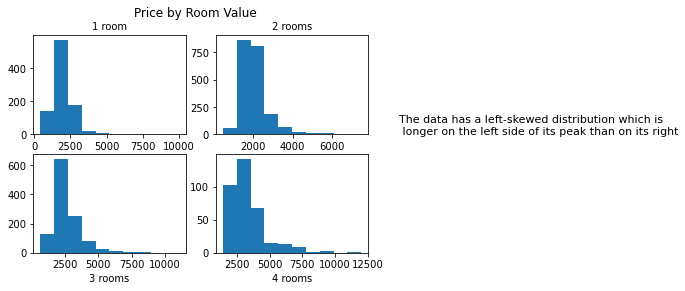

In [9]:
plot_df = berlin.dropna(axis=0, how='any')

group1 = plot_df[plot_df.Rooms == 1]
group2 = plot_df[plot_df.Rooms==2]
group3 = plot_df[plot_df.Rooms==3]
group4 = plot_df[plot_df.Rooms==4]

price1 = group1.loc[:, 'Price']
price2 = group2.loc[:, 'Price']
price3 = group3.loc[:, 'Price']
price4 = group4.loc[:, 'Price']

data_price = [price1, price2, price3, price4]

f, a = plt.subplots(2,2)
a = a.ravel()
for idx, ax in enumerate(a):
    ax.hist(data_price[idx])
    
textstr = 'The data has a left-skewed distribution which is \n longer on the left side of its peak than on its right'


plt.text(1.2, 1.2, textstr, fontsize=11, transform=ax.transAxes)
    
    
plt.subplot(221)
plt.title("1 room", fontsize=10)

plt.subplot(222)
plt.title("2 rooms", fontsize=10)

plt.subplot(223)
plt.xlabel('3 rooms')

plt.subplot(224)
plt.xlabel('4 rooms')
    

plt.suptitle('Price by Room Value', size= 12);

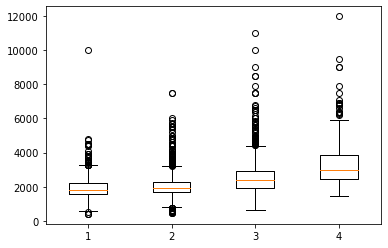

In [10]:
plt.boxplot([group1['Price'], group2['Price'], group3['Price'], group4['Price']]);

In [11]:
def UpperLowerLimitPrice(berlin):
    group_price = berlin.groupby('Rooms')['Price']
    upper_limit = group_price.mean() + group_price.std()
    lower_limit = group_price.mean() - group_price.std()
    print("Upper limit:", upper_limit, 'Lower limit:', lower_limit)

    
UpperLowerLimitPrice(berlin)

Upper limit: Rooms
1    2607.510910
2    2763.658948
3    3641.088452
4    4734.760659
Name: Price, dtype: float64 Lower limit: Rooms
1    1226.954458
2    1389.703613
3    1523.919353
4    1954.582117
Name: Price, dtype: float64


In [12]:
room1 = berlin[berlin.Rooms == 1]
room2 = berlin[berlin.Rooms == 2]
room3 = berlin[berlin.Rooms == 3]
room4 = berlin[berlin.Rooms == 4]

ser1 = room1.Price.between(1226.95, 2607.51) 
ser2 = room2.Price.between(1389.70, 2763.65) 
ser3 = room3.Price.between(1523.91, 3641.08) 
ser4 = room4.Price.between(1954.58, 4734.76)

series_price = [ser1, ser2, ser3, ser4]
series_price_combine = pd.concat(series_price)

berlin['Outlier_price'] = series_price_combine

### Detecting outliers -  area

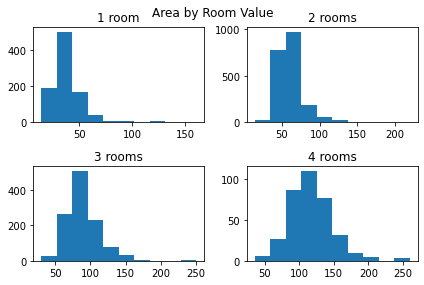

In [13]:
area1 = group1.loc[:, 'Area']
area2 = group2.loc[:, 'Area']
area3 = group3.loc[:, 'Area']
area4 = group4.loc[:, 'Area']

data_area = [area1, area2, area3, area4]

f, a = plt.subplots(2,2)
a = a.ravel()
for idx, ax in enumerate(a):
    ax.hist(data_area[idx])  


plt.subplot(221)
plt.title("1 room")

plt.subplot(222)
plt.title("2 rooms")

plt.subplot(223)
plt.title("3 rooms")

plt.subplot(224)
plt.title("4 rooms")    
    
plt.tight_layout()
plt.suptitle('Area by Room Value', size= 12);

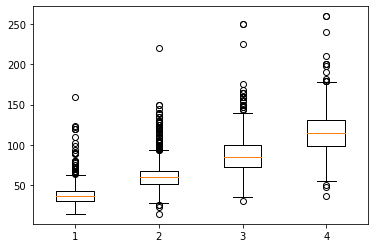

In [14]:
plt.boxplot([group1['Area'], group2['Area'], group3['Area'], group4['Area']]);

In [15]:
def UpperLowerLimitArea(berlin):
    group_area = berlin.groupby('Rooms')['Area']
    upper_Limit = (group_area.mean() + 1.5*group_area.std())
    lower_limit = (group_area.mean() - 1.5*group_area.std())
    print('Upper limit:', upper_Limit, 'Lower limit:', lower_limit)
    

UpperLowerLimitArea(berlin)

Upper limit: Rooms
1     59.478416
2     86.052947
3    123.020565
4    163.426797
Name: Area, dtype: float64 Lower limit: Rooms
1    16.493567
2    37.081470
3    52.922193
4    70.952806
Name: Area, dtype: float64


In [16]:
ser1 = room1.Area.between(16.49, 59.47) 
ser2 = room2.Area.between(37.08, 86.05) 
ser3 = room3.Area.between(52.92, 123.02) 
ser4 = room4.Area.between(70.95, 163.42)

series_area = [ser1, ser2, ser3, ser4]
series_area_combine = pd.concat(series_area)

berlin['Outlier_area'] = series_area_combine

# Removing outliers

In [17]:
berlin.loc[berlin.Price.isna(), 'Outlier_price'] = True

In [18]:
berlin = (berlin
 .query('Outlier_price == True & Outlier_area == True') #dropping all outliers
 .drop(['Outlier_price', 'Outlier_area'], axis=1)
 .assign(Price = berlin.Price.fillna(berlin.groupby('Rooms')['Price']  #filling missing values with average price
                                     .transform('mean')
                                     .round()))
 .reset_index(drop=True)
)

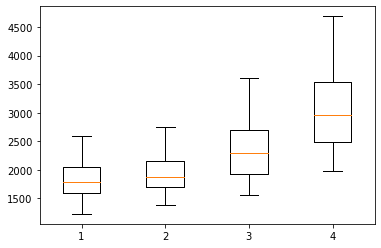

In [19]:
room_1 = berlin[berlin.Rooms == 1]
room_2 = berlin[berlin.Rooms == 2]
room_3 = berlin[berlin.Rooms == 3]
room_4 = berlin[berlin.Rooms == 4]

plt.boxplot([room_1['Price'], room_2['Price'], room_3['Price'], room_4['Price']]);

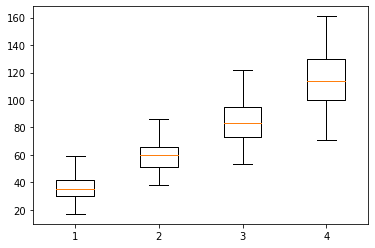

In [20]:
plt.boxplot([room_1['Area'], room_2['Area'], room_3['Area'], room_4['Area']]);

In [21]:
t1 = berlin.groupby('Rooms')['Price'].agg(['count', 'mean', 'std', 'min', 'max'])
t2 = berlin.groupby('Rooms')['Area'].agg(['count', 'mean', 'std', 'min', 'max'])

display(t1, t2)

,count,mean,std,min,max
Rooms,,,,,
1,689,1857.193033,349.518347,1227.0,2595.0
2,1583,1927.636134,312.913660,1390.0,2750.0
3,877,2340.326112,495.283970,1550.0,3600.0
4,269,3060.947955,694.097264,1979.0,4690.0


,count,mean,std,min,max
Rooms,,,,,
1,689,35.626996,9.124234,17,59
2,1583,59.219836,10.441321,38,86
3,877,84.106043,15.418483,53,122
4,269,114.468401,20.479967,71,161


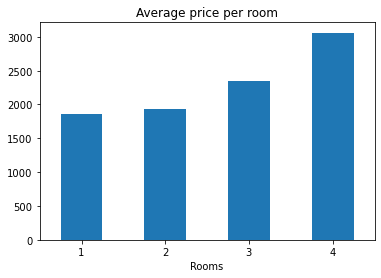

In [50]:
berlin.groupby('Rooms')['Price'].mean().plot(kind='bar')
plt.title('Average price per room')
plt.xticks(rotation=0);

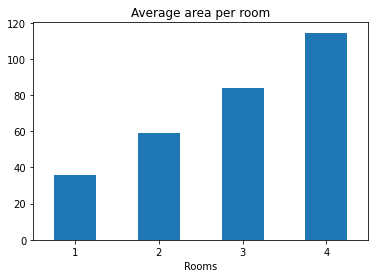

In [51]:
berlin.groupby('Rooms')['Area'].mean().plot(kind='bar')
plt.title('Average area per room')
plt.xticks(rotation=0);

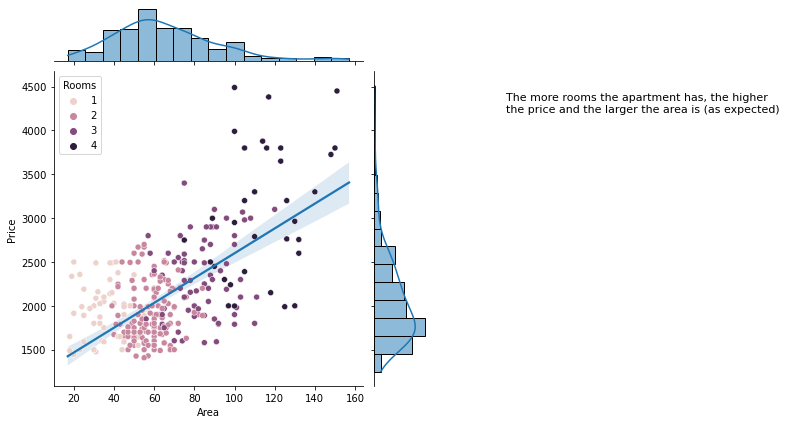

In [22]:
g = sns.jointplot(data=berlin.sample(300), x= 'Area', y='Price', kind='reg', scatter=False)
sns.scatterplot(data=berlin.sample(300), x= 'Area', y='Price', hue='Rooms', ax=g.ax_joint)
text = 'The more rooms the apartment has, the higher \nthe price and the larger the area is (as expected)'
plt.text(1.5, 3, text, fontsize=11, transform=ax.transAxes);

In [23]:
#berlin.to_excel('BERLIN.xlsx')

# The Relationship Between Location and Price

In this part we will use *GeoPy* to try to find out the **location** of the apartments. Using **latitude and longitude** we will calculate the distance from the center (in this case *Berlin Mitte*). We will only consider apartments that have indicated their street in the location column (*total 1011 rows*).

In [24]:
#importing libraries
from geopy.geocoders import Nominatim
from geopy import distance
geolocator = Nominatim(user_agent="geoapiExercise")
center_point = 'Berlin Mitte'
address = geolocator.geocode(center_point) #getting longitude, latitude of Berlin center (Berlin Mitte)
lat, lon = (address.latitude), (address.longitude)
fixed_coordinates = (lat, lon)

In [25]:
#creating new data with appropriate dataset
position_df = (berlin
 .query('Location!= "Berlin"')
 .reset_index(drop=True)

)

In [26]:
# removing values that only have the word Berlin and a postal code in it
position_df['Location_filtered'] = position_df.Location.apply(lambda x: len(x) == 12)

position_df = (position_df
 .query('Location_filtered == False')
 .assign(Coordinates = position_df.Location.apply(geolocator.geocode, timeout=10)
 )

)

In [27]:
position_df = (position_df
 .assign(Latitude = position_df.Coordinates.apply(lambda x: x.latitude if x != None else None), #latitude
         Longitude = position_df.Coordinates.apply(lambda x: x.longitude if x!= None else None)) #longitude
 .dropna(how='any', axis=0)
 .reset_index(drop=True)

)

In [28]:
position_df = (position_df
 .assign(Distance = position_df.apply(lambda row: distance.distance((row.Latitude, row.Longitude), fixed_coordinates).km, axis=1)
         .round(1)) #distance in km
 .drop(['Location_filtered', 'Coordinates', 'Latitude', 'Longitude'], axis=1)

)

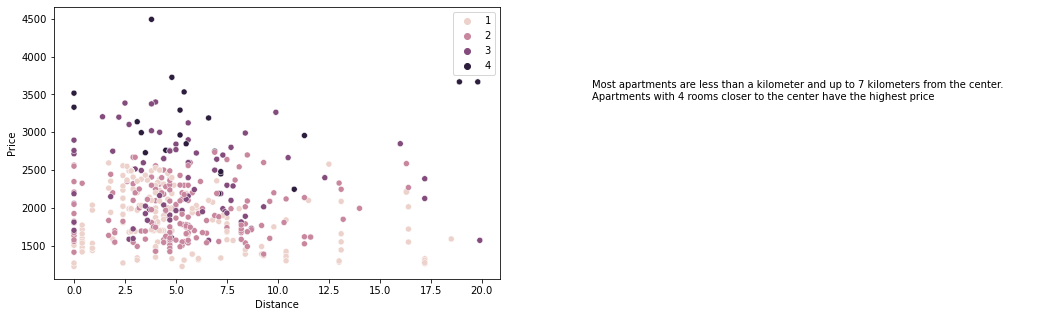

In [29]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=position_df, x='Distance', y='Price', hue='Rooms')
plt.legend(loc='upper right');
description = ('Most apartments are less than a kilometer and up to 7 kilometers from the center. \
               \nApartments with 4 rooms closer to the center have the highest price')
plt.text(2, 2, description, transform=ax.transAxes);

In [30]:
#position_df.to_excel('BERLIN_DISTANCE.xlsx')

# Comparison of Berlin and Hamburg

In this part we will load data about Hamburg to compare the average prices. **Reminder:** Berlin's data size is 4465 while Hamburg's is 594

In [31]:
hamburg_df = pd.read_excel('C:/Users/Marijana/Desktop/Pr/Hamburg/HAMBURG.xlsx').drop('Unnamed: 0', axis=1)

In [32]:
#creating new dataframes with average values for price and area columns

berlin_avg = pd.DataFrame(berlin.groupby('Rooms')[['Area', 'Price']].mean()).reset_index()
berlin_avg['City'] = 'Berlin'

hamburg_avg = pd.DataFrame(hamburg_df.groupby('Rooms')[['Area', 'Price']].mean()).reset_index()
hamburg_avg['City'] = 'Hamburg'

In [33]:
cities = pd.concat([berlin_avg, hamburg_avg])

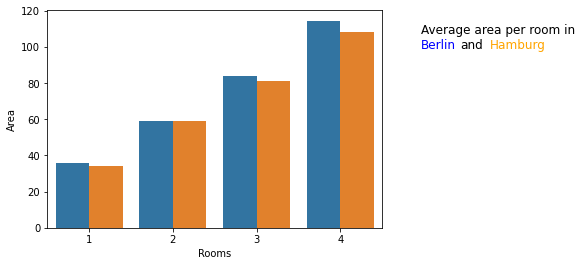

In [34]:
txt1 = 'Average area per room in\n'
txt2 = 'Berlin'
txt3 = 'and'
txt4 = 'Hamburg'

plt.text(1, 2, txt1, fontsize=12, transform=ax.transAxes)
plt.text(1, 2, txt2, fontsize=12, color='b', transform=ax.transAxes)
plt.text(1.23, 2, txt3, fontsize=12, transform=ax.transAxes)
plt.text(1.4, 2, txt4, fontsize=12, color='orange', transform=ax.transAxes)

sns.barplot(data=cities, x='Rooms', y='Area', hue='City').legend_.remove();

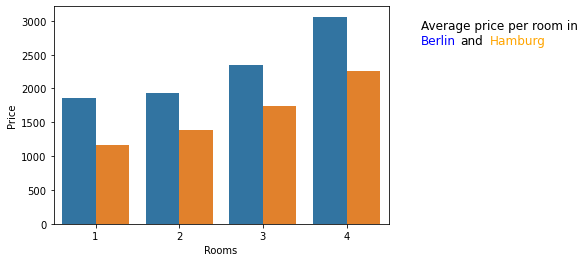

In [35]:
text1 = 'Average price per room in\n'
text2 = 'Berlin'
text3 = 'and'
text4 = 'Hamburg'

plt.text(1, 2, text1, fontsize=12, transform=ax.transAxes)
plt.text(1, 2, text2, fontsize=12, color='b', transform=ax.transAxes)
plt.text(1.23, 2, text3, fontsize=12, transform=ax.transAxes)
plt.text(1.4, 2, text4, fontsize=12, color='orange', transform=ax.transAxes)


sns.barplot(data=cities, x='Rooms', y='Price', hue='City').legend_.remove();